# DATASET AUGMENTATION

In [1]:
import os
import cv2
import numpy as np
import glob

# Base directory for the dataset (relative path)
base_dir = os.path.join(os.path.dirname(__file__), 'rps-cv-images')

# Directories for each class
classes = ['paper', 'rock', 'scissors']
augmented_dirs = ['prep_paper', 'prep_rock', 'prep_scissors']

# Create new directories for augmented images
for aug_dir in augmented_dirs:
    os.makedirs(os.path.join(base_dir, aug_dir), exist_ok=True)

# Function to adjust hue
def adjust_hue(image, delta):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image_hsv[..., 0] = (image_hsv[..., 0] + delta) % 180  # Adjust hue
    return cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)

# Function to adjust saturation
def adjust_saturation(image, factor):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image_hsv[..., 1] = np.clip(image_hsv[..., 1] * factor, 0, 255)  # Adjust saturation
    return cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)

# Function to perform augmentations
def augment_and_save_images(class_name):
    class_path = os.path.join(base_dir, class_name)
    augmented_path = os.path.join(base_dir, f'prep_{class_name}')

    # Get all image files in the class directory
    image_files = glob.glob(os.path.join(class_path, '*'))

    for image_file in image_files:
        # Read the image
        image = cv2.imread(image_file)
        if image is None:
            continue  # Skip if the image is not read properly

        # 1. Flip horizontally
        flipped_h = cv2.flip(image, 1)
        cv2.imwrite(os.path.join(augmented_path, f'horizontal_{os.path.basename(image_file)}'), flipped_h)

        # 2. Flip vertically
        flipped_v = cv2.flip(image, 0)
        cv2.imwrite(os.path.join(augmented_path, f'vertical_{os.path.basename(image_file)}'), flipped_v)

        # 3. Rotate by 30, 45, 60, and 90 degrees
        for angle in [30, 45, 60, 90]:
            (h, w) = image.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated = cv2.warpAffine(image, M, (w, h))
            cv2.imwrite(os.path.join(augmented_path, f'rotated_{angle}_{os.path.basename(image_file)}'), rotated)

        # 4. Adjust hue and saturation
        for hue_shift in [-10, 10]:
            hue_adjusted = adjust_hue(image, hue_shift)
            for saturation_factor in [0.5, 1.0, 1.5, 2.0]:
                saturated_image = adjust_saturation(hue_adjusted, saturation_factor)
                cv2.imwrite(os.path.join(augmented_path, f'hue_{hue_shift}_sat_{saturation_factor}_{os.path.basename(image_file)}'), saturated_image)

# Perform augmentations for each class
for class_name in classes:
    augment_and_save_images(class_name)

print("Augmentation completed and images saved.")

NameError: name '__file__' is not defined

# Split Data use Image Data Generator

In [1]:
import os
import cv2
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base directory for the dataset (absolute path)
base_dir = r"C:\Users\dewam\Project Machine Learning and Data Science\rockpaperscissors\rps-cv-images"

# Create an instance of ImageDataGenerator without augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    validation_split=0.4  # Use 40% of the data for validation
)

# Create training data generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Set as training data
    classes=['paper', 'rock', 'scissors']  # Specify the class directories
)

# Create validation data generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Set as validation data
    classes=['paper', 'rock', 'scissors']  # Specify the class directories
)

# Print class indices to see the labels
print("Class indices:", train_generator.class_indices)

Found 18380 images belonging to 3 classes.
Found 12252 images belonging to 3 classes.
Class indices: {'paper': 0, 'rock': 1, 'scissors': 2}


# Modeling

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

# Membuat model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

c:\Users\dewam\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,147 (13.18 MB)

 Trainable params: 3,454,147 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

# Hyper Parameter Tuning

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard

# Define the callbacks
callbacks = []

# ModelCheckpoint: Save the model after every epoch if the validation accuracy improves
checkpoint = ModelCheckpoint(
    'rockpaperscissors.keras',  # Path to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode='max',  # Maximize the monitored quantity
    verbose=1  # Print messages when saving the model
)
callbacks.append(checkpoint)

# EarlyStopping: Stop training when the validation loss has stopped improving
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Print messages when stopping
    mode='min',  # Minimize the monitored quantity
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
callbacks.append(early_stopping)

# LearningRateScheduler: Schedule to change the learning rate
def scheduler(epoch, lr):
    if epoch > 10:  # After 10 epochs
        return lr * 0.1  # Reduce learning rate by a factor of 10
    return lr

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)
callbacks.append(lr_scheduler)

# TensorBoard: Log metrics for visualization
tensorboard = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=True, write_images=True)
callbacks.append(tensorboard)

# Train the model with the defined callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=5,
    verbose=2,
    callbacks=callbacks  # Include the callbacks here
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100


c:\Users\dewam\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.35000, saving model to rockpaperscissors.keras
25/25 - 19s - 755ms/step - accuracy: 0.4325 - loss: 1.0740 - val_accuracy: 0.3500 - val_loss: 1.0692 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100

Epoch 2: val_accuracy improved from 0.35000 to 0.66875, saving model to rockpaperscissors.keras
25/25 - 11s - 433ms/step - accuracy: 0.6513 - loss: 0.7988 - val_accuracy: 0.6687 - val_loss: 0.8792 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100

Epoch 3: val_accuracy improved from 0.66875 to 0.81875, saving model to rockpaperscissors.keras
25/25 - 10s - 419ms/step - accuracy: 0.7900 - loss: 0.5482 - val_accuracy: 0.8188 - val_loss: 0.5386 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100

Epoch 4: val_accuracy improved from 0.81875 to 0.83750, savi

c:\Users\dewam\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 24: val_accuracy did not improve from 0.93125
25/25 - 2s - 72ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8813 - val_loss: 0.5073 - learning_rate: 1.0000e-16

Epoch 25: LearningRateScheduler setting learning rate to 1.0000000830368326e-17.
Epoch 25/100

Epoch 25: val_accuracy did not improve from 0.93125
25/25 - 11s - 435ms/step - accuracy: 0.9550 - loss: 0.1234 - val_accuracy: 0.9000 - val_loss: 0.2454 - learning_rate: 1.0000e-17

Epoch 26: LearningRateScheduler setting learning rate to 1.0000000664932204e-18.
Epoch 26/100

Epoch 26: val_accuracy did not improve from 0.93125
25/25 - 12s - 473ms/step - accuracy: 0.9625 - loss: 0.1054 - val_accuracy: 0.8875 - val_loss: 0.3236 - learning_rate: 1.0000e-18

Epoch 27: LearningRateScheduler setting learning rate to 1.000000045813705e-19.
Epoch 27/100

Epoch 27: val_accuracy did not improve from 0.93125
25/25 - 12s - 463ms/step - accuracy: 0.9600 - loss: 0.1105 - val_accuracy: 0.8875 - val_loss: 0.5735 - learning

# Model Evaluation

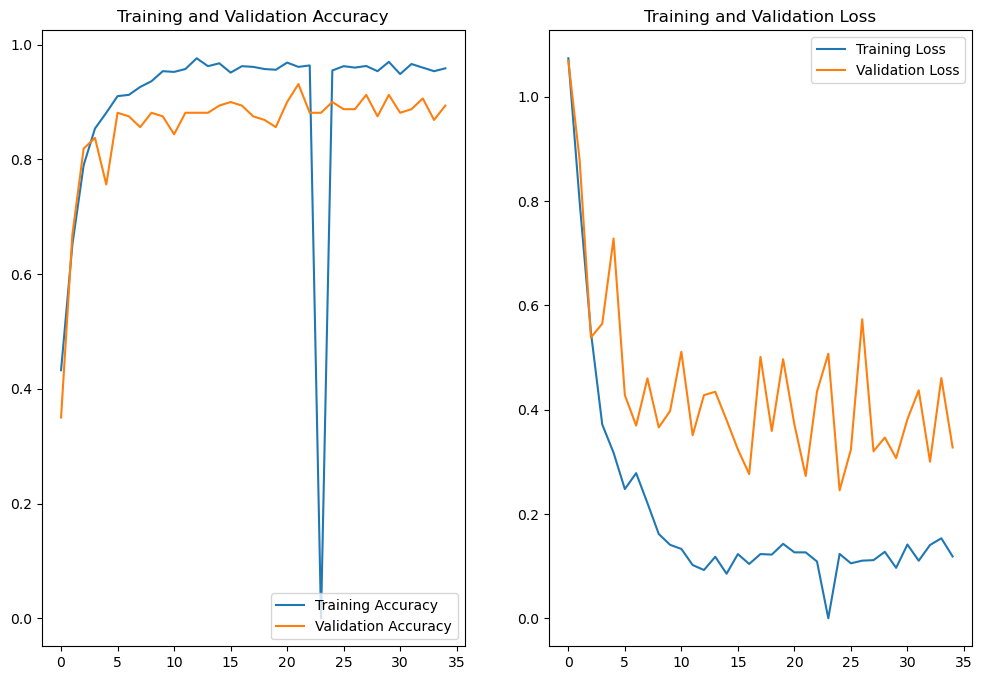

In [4]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable that holds the training history
# Evaluate the model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the plots
plt.show()

# Load Model & Data Test

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import os

class ImageClassifierApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Rock Paper Scissors Classifier")
        
        # Load model
        try:
            model_path = r"C:\Users\dewam\Project Machine Learning and Data Science\rockpaperscissors\rockpaperscissors.keras"
            self.model = tf.keras.models.load_model(model_path)
            self.class_names = ['paper', 'rock', 'scissors']
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load model: {str(e)}")
            root.destroy()
            return

        # Create GUI elements
        self.create_widgets()

    def create_widgets(self):
        # Upload button
        self.upload_btn = Button(self.root, text="Upload Image", command=self.upload_image)
        self.upload_btn.pack(pady=10)

        # Image display label
        self.image_label = Label(self.root)
        self.image_label.pack(pady=10)

        # Prediction label
        self.pred_label = Label(self.root, text="", font=("Arial", 12))
        self.pred_label.pack(pady=10)

    def upload_image(self):
        try:
            # Open file dialog
            file_path = filedialog.askopenfilename(
                title="Select Image",
                filetypes=[("Image files", "*.jpg;*.jpeg;*.png")]
            )
            
            if not file_path:
                return

            # Load and display image
            img = Image.open(file_path)
            img = img.resize((150, 150))
            
            # Display image in GUI
            photo = ImageTk.PhotoImage(img)
            self.image_label.config(image=photo)
            self.image_label.image = photo

            # Process image for prediction
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0

            # Make prediction
            predictions = self.model.predict(img_array)
            predicted_class = self.class_names[np.argmax(predictions[0])]
            confidence = np.max(predictions[0]) * 100

            # Update prediction label
            self.pred_label.config(
                text=f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%"
            )

        except Exception as e:
            messagebox.showerror("Error", f"Error processing image: {str(e)}")

def main():
    root = Tk()
    app = ImageClassifierApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()